
# **Autoencoders PyTorch usando o conjunto de dados Fashion-MNIST**

---


Nesta lição, implementaremos um **Autoencoder no conjunto de dados Fashion MNIST** usando PyTorch


Um autoencoder é um algoritmo de aprendizado de máquina não supervisionado. Em nosso exemplo aqui, ele recebe uma imagem como entrada e tenta reconstruir essa imagem usando menos informações.

Isso é feito projetando dados de dimensões mais altas para uma dimensão mais baixa (semelhante à Análise de Componentes Principais), mantendo as características mais importantes. Isso é chamado de espaço latente. 

![](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1522830223/AutoEncoder_kfqad1.png)

### **Um autoencoder é composto por estas duas redes**

**Codificador**: comprime/reduz a imagem de entrada para um número menor de bits. Este número menor de bits é chamado de espaço latente ou gargalo. 

**Decodificador**: tenta reconstruir a entrada usando apenas a codificação da entrada. Se o decodificador conseguir reconstruir a imagem com precisão a partir da saída do codificador, você tem um codificador (capaz de produzir boas codificações) e um sistema decodificador funcionando corretamente.

**Crédito do tutorial:**

https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/


In [1]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

## **2. Carregue nossos dados, crie nossas transformações, defina nossas constantes e crie nossos carregadores de dados**

In [2]:
# constants
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

# image transformations
transform = transforms.Compose([transforms.ToTensor(),])

In [3]:
# Load our FashionMNIST dataset
trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform)

testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform)

100%|██████████| 26.4M/26.4M [00:13<00:00, 1.95MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 140kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 35.7MB/s]


In [4]:
# Create our Data Loaders
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True)

testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

## **3. Criar nosso modelo de autoencoder**

**Primeiro, algumas funções utilitárias**

In [5]:
# Firstly make some utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

### **Criar nossa classe do modelo**

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)

        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


### **Definindo nossa função de perda e otimizador**

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

## **4. Treinando nosso modelo**

#### **Definir nossas funções de treinamento e teste** 

In [8]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))

        if epoch % 5 == 0:
            save_decoded_image(outputs.cpu().data, epoch)

    return train_loss

def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        img = img.view(img.size(0), -1)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction.png')
        break


cuda:0
Epoch 1 of 50, Train Loss: 0.074
Epoch 2 of 50, Train Loss: 0.043
Epoch 3 of 50, Train Loss: 0.038
Epoch 4 of 50, Train Loss: 0.031
Epoch 5 of 50, Train Loss: 0.028
Epoch 6 of 50, Train Loss: 0.026
Epoch 7 of 50, Train Loss: 0.024
Epoch 8 of 50, Train Loss: 0.023
Epoch 9 of 50, Train Loss: 0.023
Epoch 10 of 50, Train Loss: 0.022
Epoch 11 of 50, Train Loss: 0.021
Epoch 12 of 50, Train Loss: 0.020
Epoch 13 of 50, Train Loss: 0.020
Epoch 14 of 50, Train Loss: 0.019
Epoch 15 of 50, Train Loss: 0.019
Epoch 16 of 50, Train Loss: 0.018
Epoch 17 of 50, Train Loss: 0.018
Epoch 18 of 50, Train Loss: 0.018
Epoch 19 of 50, Train Loss: 0.018
Epoch 20 of 50, Train Loss: 0.018
Epoch 21 of 50, Train Loss: 0.018
Epoch 22 of 50, Train Loss: 0.018
Epoch 23 of 50, Train Loss: 0.018
Epoch 24 of 50, Train Loss: 0.017
Epoch 25 of 50, Train Loss: 0.017
Epoch 26 of 50, Train Loss: 0.017
Epoch 27 of 50, Train Loss: 0.017
Epoch 28 of 50, Train Loss: 0.017
Epoch 29 of 50, Train Loss: 0.017
Epoch 30 of 50, 

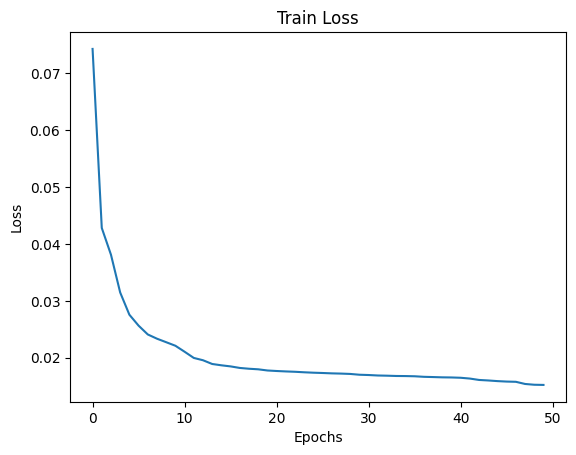

In [9]:
# get the computation device
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)

make_dir()

# train the network
train_loss = train(net, trainloader, NUM_EPOCHS)

# Plot training results
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('deep_ae_fashionmnist_loss.png')

# test the network
test_image_reconstruction(net, testloader)

## **5. Exibindo nossos resultados**

Veja nossas imagens reconstruídas.

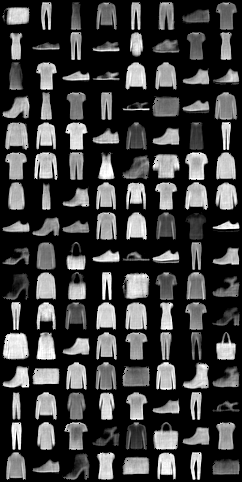

In [14]:
from IPython.display import Image

Image('fashionmnist_reconstruction.png')

### **Vendo os originais**

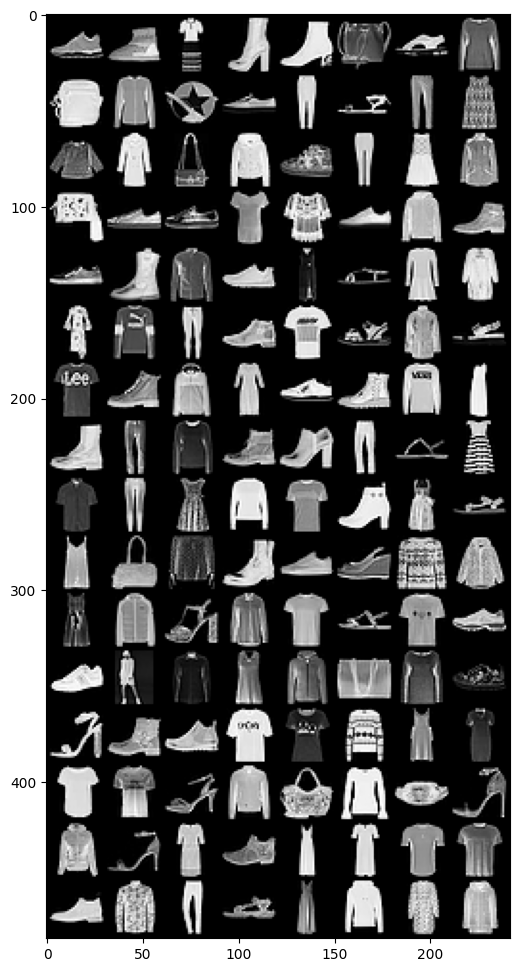

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

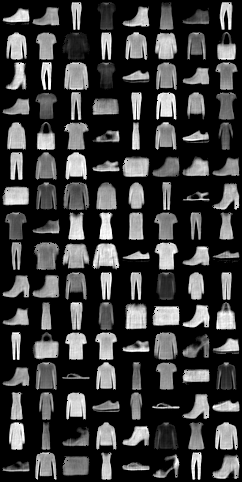

In [19]:
test_image_reconstruction(net, trainloader)
Image('fashionmnist_reconstruction.png')